# 📌 Intro.
- 그동안 배운 딥러닝개념 및 실습의 내용을 활용해 총 3개의 프로젝트를 진행합니다.
    - Boston 주택 가격 예측 모델 : 주택 가격을 예측하는 회귀(Regression)모델 by 딥러닝
    - Reuters 딥러닝 모델 : Reuters의 뉴스기사/금융정보 데이터를 분류하는 모델
    - CIFAR10 딥러닝 모델 : 다양한 동물(10개클래스) 데이터를 분류하는 모델

---

- 이중 첫번째 프로젝트인 Boston 주택 가격 예측 모델 프로젝트를 수행하며, 데이터의 각 feature는 아래와 같은 의미를 지닙니다.

<center>

|   Feature   |                  설명                  |
|:-----------:|:--------------------------------------:|
|    CRIM     |        자치시별 1인당 범죄율           |
|     ZN      | 25,000 평방피트를 초과하는 거주지역의 비율 |
|    INDUS    |    비소매상업지역이 점유하고 있는 토지의 비율 |
|    CHAS     | 찰스강에 대한 더미변수(강의 경계에 위치한 경우는 1, 아니면 0) |
|    NOX      |       10ppm 당 농축 일산화질소          |
|     RM      |        주택 1 가구당 평균 방의 개수     |
|    AGE      |   1940년 이전에 건축된 소유주택의 비율  |
|    DIS      |     5개의 보스턴 직업센터까지의 접근성 지수 |
|    RAD      |       방사형 도로까지의 접근성 지수       |
|    TAX      |      10,000 달러당 재산세율            |
|   PTRATIO   | 자치시(town)별 학생/교사 비율          |
|     B       | 1000 x (Bk - 0.63)^2, 여기서 Bk는 자치시별 흑인의 비율을 말함 |
|   LSTAT     |       모집단의 하위계층의 비율(%)       |
|    MEDV     | 본인 소유의 주택가격(중앙값)(단위: $1,000) |

</center>

In [1]:
# GPU 세팅
import tensorflow as tf

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # 메모리 사용 제한을 위한 설정
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
            # 특정 GPU만 사용하도록 설정
        tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
    except RuntimeError as e:
        # 프로그램 시작 후에는 GPU 설정을 변경할 수 없으므로
        # 런타임 오류 발생 시 예외 처리가 필요함
        print(e)
        
import warnings

# 경고 메시지 무시
warnings.filterwarnings("ignore")

Num GPUs Available:  1


## 데이터 로드 및 전처리

- 1바퀴 코드를 돌려서 처리하고 보니, 결과는 잘 나오는데, ML처럼 어떤 변수가 어느정도의 영향력이 있는지, 어떤게 좋은 변수인지를 파악 할 수가 없습니다.
- 신경망에 입력되는 데이터는 그저 벡터화된 숫자들일뿐이기 때문입니다.
- 이에 변수명을 데이터 로드시에 맵핑하여 차후에 Permutation imprtance를 출력해서 최종 모델에 어떤 변수가 주요 변수로 작용했는지를 살펴보려고 합니다.
- 데이터를 분석하는 이유는 단순히 결과만을 보는것이 아니라, 그 결과가 나온 과정과 세부사항을 알 수 있도록 하는 것이 주 목적이고, 그것이 제대로된 데이터 분석이라 생각하기 때문입니다.

---

- ML 처럼 Feature importance를 출력할 수 있다면 좋겠지만 이는 트리 기반 모델에 특화된 것으로 현실적인 방법을 찾아봤습니다. 
- 첫번째는 모델의 회귀계수를 분석해서 SHAP라는 모듈로 변수별 중요도를 파악하는 방법이고, 두번째는 Permutation importance를 사용해 각 변수별 중요도를 추론하는 방법입니다.
- 상세한 내용은 실제 코드 실행부분에서 다루겠습니다.

In [2]:
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
# keras.datasets 안에 boston_housing 데이터셋을 로드합
from keras.datasets import boston_housing

# 보스턴 주택 가격 데이터셋 로드
(train_data, train_labels), (test_data, test_labels) = boston_housing.load_data()

# 변수 이름 리스트 생성
# 모델 결과 해석시 사용
feature_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

# 훈련 데이터와 테스트 데이터 크기 확인
print("훈련 데이터 개수:", len(train_data))
print("테스트 데이터 개수:", len(test_data))

훈련 데이터 개수: 404
테스트 데이터 개수: 102


### 표준화 / 표준편차 적용

- 특성(변수)별로 스케일이 다른 경우, 회귀 모델은 값이 큰 변수에 더 큰 가중치를 부여 하므로, 스케일을 같은 범위로 정규화해야 합니다.
- 먼저 각 스케일에서 평균을 빼면 데이터의 중심이 0값을 중심으로 재구성됩니다.
- 이후 표준편차가 1이 되도록 만듬으로 인해 데이터가 선형성을 띌 수 있도록 합니다.
- 이렇게 하면 모델이 데이터를 더 정확하게 학습할 수 있습니다.
    - 선형회귀의 기본 전제는 데이터가 정규분포를 따른다는 것입니다.

In [3]:
# 문제 1-1: 데이터셋의 전처리를 위해 표준화 작업을 수행합니다.
# 먼저 입력 데이터의 각 특성의 평균을 뺍니다.
mean = train_data.mean(axis=0)
train_data -= mean

# 평균을 뺀 입력 데이터에서 표준편차 나누기
# 데이터 특성의 중앙이 0에 가깝게 만들고, 표준편차가 1이 되게 만들기
std = train_data.std(axis=0)
train_data /= std

# 테스트 데이터셋도 마찬가지로 평균을 빼고, 표준편차로 나누기
test_data -= mean
test_data /= std

## 모델 구성 및 컴파일

In [4]:
# 모델 구성
model = models.Sequential()  # Sequential 모델을 생성 (순차적으로 레이어를 쌓는 모델)

# 64개 뉴런과 'relu' 활성화 함수를 가진 첫 번째 레이어를 추가 입력 형태는 훈련 데이터의 특성 수에 해당
model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))  

# 64개 뉴런과 'relu' 활성화 함수를 가진 두 번째 레이어를 추가
model.add(layers.Dense(64, activation='relu'))  
model.add(layers.Dense(1))  # 회귀 모델이므로 출력 레이어는 하나의 뉴런으로 y에 대한 예측값만 출력

# 모델 요약 정보 출력
model.summary()  # 모델의 구조와 파라미터 수 등을 요약하여 출력

# 모델 컴파일
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])  # 'rmsprop' 옵티마이저, 'mse' 손실 함수 (평균 제곱 오차), 'mae' 메트릭 (평균 절대 오차)를 사용하여 모델을 컴파일

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


## 모델 학습

In [5]:
epochs = 100  # 모델이 전체 훈련 데이터셋을 몇 번 반복하여 학습할 것인지 설정
batch_size = 16  # 한 번에 모델이 처리할 데이터 샘플의 개수를 설정

# 모델 학습
history = model.fit(
    train_data,        # 훈련 데이터
    train_labels,      # 훈련 레이블
    epochs=epochs,     # epoch 수 (전체 훈련 데이터를 몇 번 반복하여 학습할지 지정)
    batch_size=batch_size,  # 미니 배치 크기 (한 번에 처리할 샘플의 개수)
    validation_split=0.2   # 검증 데이터 분할 비율 (전체 훈련 데이터 중 일부를 검증 데이터로 사용)
)

Epoch 1/100
21/21 [==============================] - 1s 6ms/step - loss: 502.5213 - mae: 20.5953 - val_loss: 505.0795 - val_mae: 20.6440
Epoch 2/100
21/21 [==============================] - 0s 3ms/step - loss: 370.0215 - mae: 17.2469 - val_loss: 356.6407 - val_mae: 16.8179
Epoch 3/100
21/21 [==============================] - 0s 4ms/step - loss: 227.7861 - mae: 12.9200 - val_loss: 206.9331 - val_mae: 11.6309
Epoch 4/100
21/21 [==============================] - 0s 3ms/step - loss: 123.1720 - mae: 8.6393 - val_loss: 125.7501 - val_mae: 8.5546
Epoch 5/100
21/21 [==============================] - 0s 2ms/step - loss: 76.9965 - mae: 6.4972 - val_loss: 83.2089 - val_mae: 6.7706
Epoch 6/100
21/21 [==============================] - 0s 3ms/step - loss: 54.6069 - mae: 5.3607 - val_loss: 64.0066 - val_mae: 5.8261
Epoch 7/100
21/21 [==============================] - 0s 3ms/step - loss: 42.9517 - mae: 4.5881 - val_loss: 48.0379 - val_mae: 5.0727
Epoch 8/100
21/21 [==============================] - 0s

21/21 [==============================] - 0s 2ms/step - loss: 7.1456 - mae: 1.8294 - val_loss: 17.7756 - val_mae: 2.6691
Epoch 63/100
21/21 [==============================] - 0s 3ms/step - loss: 7.0969 - mae: 1.8202 - val_loss: 17.2929 - val_mae: 2.6399
Epoch 64/100
21/21 [==============================] - 0s 2ms/step - loss: 7.0583 - mae: 1.7969 - val_loss: 16.9492 - val_mae: 2.6403
Epoch 65/100
21/21 [==============================] - 0s 3ms/step - loss: 6.8425 - mae: 1.7704 - val_loss: 16.4491 - val_mae: 2.7005
Epoch 66/100
21/21 [==============================] - 0s 3ms/step - loss: 6.7725 - mae: 1.7889 - val_loss: 18.4606 - val_mae: 2.6636
Epoch 67/100
21/21 [==============================] - 0s 2ms/step - loss: 6.8925 - mae: 1.8064 - val_loss: 17.0631 - val_mae: 2.6376
Epoch 68/100
21/21 [==============================] - 0s 2ms/step - loss: 6.6449 - mae: 1.7578 - val_loss: 15.6764 - val_mae: 2.6536
Epoch 69/100
21/21 [==============================] - 0s 2ms/step - loss: 6.7577 -

### 학습 결과 시각화

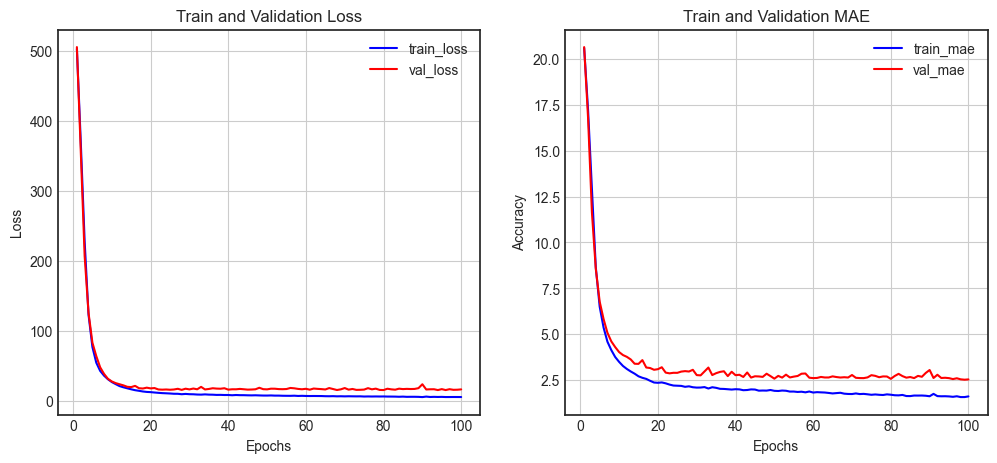

In [6]:
# 모델 학습 히스토리에서 손실(loss)과 평균 절대 오차(MAE)를 차트로 시각화
plt.style.use('seaborn-white')  # 그래프 스타일을 설정

# 모델 히스토리에서 손실과 평균 절대 오차 데이터를 추출
history_dict = history.history
loss = history_dict['loss']
val_loss = history_dict['val_loss']
mae = history_dict['mae']
val_mae = history_dict['val_mae']

epochs = range(1, len(loss) + 1)  # epoch 수를 x축으로 사용
fig = plt.figure(figsize=(12, 5))  # 그래프 크기를 설정

# 손실 그래프를 그립니다.
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(epochs, loss, 'b-', label='train_loss')  # 훈련 손실 (파란색 선)
ax1.plot(epochs, val_loss, 'r-', label='val_loss')   # 검증 손실 (빨간색 선)
ax1.set_title('Train and Validation Loss')  # 그래프 제목 설정
ax1.set_xlabel('Epochs')  # x축 레이블 설정
ax1.set_ylabel('Loss')  # y축 레이블 설정
ax1.grid()  # 격자 표시
ax1.legend()  # 범례 표시

# MAE 그래프를 그립니다.
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(epochs, mae, 'b-', label='train_mae')  # 훈련 MAE (파란색 선)
ax2.plot(epochs, val_mae, 'r-', label='val_mae')   # 검증 MAE (빨간색 선)
ax2.set_title('Train and Validation MAE')  # 그래프 제목 설정
ax2.set_xlabel('Epochs')  # x축 레이블 설정
ax2.set_ylabel('Accuracy')  # y축 레이블 설정
ax2.grid()  # 격자 표시
ax2.legend()  # 범례 표시

plt.show()  # 그래프를 화면에 출력

- epoch가 증가함에 따라 loss가 점차 감소하였고 train_loss와 test_loss의 차이도 미미합니다.
    - 이는 모델의 일반화가 잘 되고, 학습을 잘하고 있다는 증거입니다.
- MAE를 보아도 학습과 검증 모두 같은 방향으로 점차 감소하고 있고, 그 차이가 그리 크지 않습니다.

- 전반적으로 모델이 학습을 진행할 수록 데이터를 잘 학습하고 일반화도 잘 된 모델로 학습된 것 같습니다.

## 모델 평가

In [7]:
# 모델 평가
test_loss, test_mae = model.evaluate(test_data, test_labels)

# 평가 결과 출력
print("평가 손실 (MSE):", test_loss)
print("평가 MAE:", test_mae)

4/4 [==============================] - 0s 1000us/step - loss: 26.6807 - mae: 3.0888
평가 손실 (MSE): 26.68074607849121
평가 MAE: 3.088766574859619


- 실제 테스트 데이터로 확인한 결과로도 모델이 좋은 성능을 보이고 있습니다.
- 실제 y값에 대해 예측값과의 차이가 얼마나 되는지도 살펴보겠습니다.

### 모델 예측 결과 살펴보기

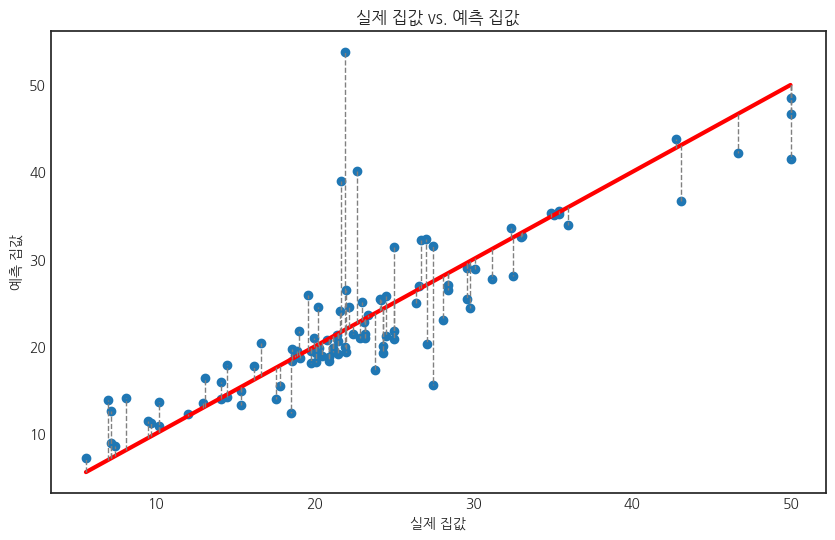

In [8]:
import matplotlib.pyplot as plt
import koreanize_matplotlib
import numpy as np

# 모델로 예측값 얻기
predictions = model.predict(test_data)

# 예측 결과와 실제 레이블 사이의 산점도 그리기
plt.figure(figsize=(10, 6))

# 실제 레이블 vs. 예측값을 그리기 위한 Scatter Plot
plt.scatter(test_labels, predictions)
plt.xlabel('실제 집값')
plt.ylabel('예측 집값')
plt.title('실제 집값 vs. 예측 집값')

# 회귀 곡선 그리기
plt.plot([min(test_labels), max(test_labels)], [min(test_labels), max(test_labels)], color='red', linewidth=3)

# 오차를 나타내는 선 그리기
for i in range(len(test_labels)):
    plt.plot([test_labels[i], test_labels[i]], [test_labels[i], predictions[i]], color='gray', linestyle='--', linewidth=1)

plt.show()

- 모델이 각 변수의 특징을 잘 파악해서 좋은 성과를 내는 모델이 된 것은 좋은 성과입니다.
- 하지만 기존의 머신러닝 처럼 어떤 변수들이 이런 결과를 내는데 주요한 변수로 작용했는지도 알고 싶습니다.

### 변수의 영향력 확인하기

- [Understanding XAI Methods || Permutation Feature Importance](https://youtu.be/DnQsEAMMmyw?si=Ja4gsnUxcYhp5IEh)
- [[해석할 수 있는 기계학습(5-5)] 순열 특성 중요도(Permutation Feature Importance)](https://eair.tistory.com/24)
- [How to explain neural networks using SHAP](https://www.yourdatateacher.com/2021/05/17/how-to-explain-neural-networks-using-shap/)
- [SHAP에 대한 모든 것 - part 3 : SHAP을 통한 시각화해석](https://datanetworkanalysis.github.io/2019/12/24/shap3)
- [SHAP value에 대한 간단한 소개(with Python)](https://zzinnam.tistory.com/entry/SHAP-value%EC%97%90-%EB%8C%80%ED%95%9C-%EA%B0%84%EB%8B%A8%ED%95%9C-%EC%86%8C%EA%B0%9Cwith-Python)
- [Permutation Importance & Partial Dependence Plot 정리](https://bongholee.com/permutation-importance-partial-dependence-plot-jeongri/)
- [Permutation Feature Importance](https://velog.io/@suhyun-guri/Permutation-Feature-Importance)

### SHAP로 각 변수의 모델 기여도 판단하기

- 중요도 분석
    - 신경망에서는 ML처럼 직접적인 Feature importance를 제공하지 않습니다.
    - 따라서 첫 번째 레이어의 가중치(각 입력 변수와 해당 뉴런간 관계)로 회귀계수를 추론합니다.
        - 신경망의 각 입력 변수의 가중치는 그 변수가 출력(y)에 얼마나 큰 영향을 미치는가를 의미하기 때문입니다.
        - 즉 가중치의 절대값이 클수록 해당 변수가 출력값에 미치는 영향이 크다고 추론할 수 있습니다.
        - 다만, 이는 가장 단순한 해석으로 신경망의 은닉층 연산으로 인해 항상 정확하지 않을 수 있습니다.
        - 따라서 이를 보완하기 위해 SHAP를 사용합니다.

- SHAP (SHapley Additive exPlanations) 수치 해석
    - SHAP는 모델의 예측에 대한 각 입력 변수의 기여도를 설명하기 위한 방법론입니다.
    - 각 변수가 있었을 때와 없었을 때의 모델 예측값 차이를 계산해서 그 변수의 기요도를 측정합니다.(일종의 게임이론)
    - 이를 통해, 변수가 모델 예측에 얼마나 영향을 미치는 가를 수치화할 수 있습니다.

- SHAP의 장점은 모델의 각 입력변수가 최종 predict 결과에 미치는 영향을 가중치보다 더 정확하게 평가할 수 있다는 점 입니다.
- 또한 단순히 변수의 영향력 뿐만 아니라 그 영향의 방향성도 보여줍니다. (어떤 변수가 예측값을 증가시키고 감소시키는데 기여하는지)

#### 단순 가중치 출력을 통한 Feature importance 추론

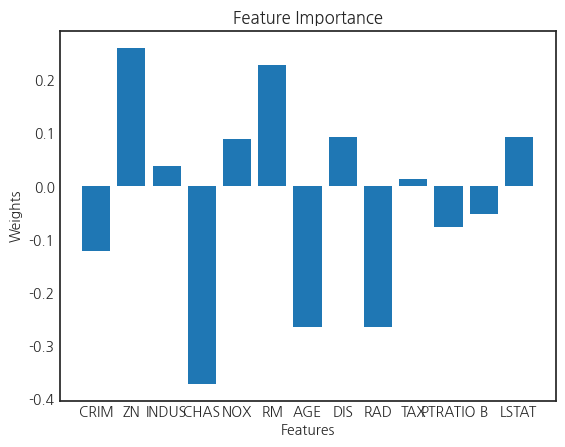

In [26]:
# 첫 번째 레이어의 가중치 추출
weights = model.layers[0].get_weights()[0]

# 가중치를 막대 그래프로 시각화
plt.bar(feature_names, weights[:,0])
plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('Feature Importance')
plt.show()

#### SHAP를 통한 Feature importance 출력

##### SHAP summary plot
- 전체 데이터 셋에 대한 변수의 평균적인 영향력을 시각화 합니다.
- 각 막대는 변수의 평균 |SHAP값| (절대값) 을 의미하며, 이는 각 변수가 모델 출력에 미치는 평균적인 영향의 크기를 의미합니다.
- summary plot은 모든 데이터의 포인트를 평균내서 각 변수가 모델 예측에 미치는 `평균적인 중요도` 를 나타내기 때문에 SHAP force plot에서 나타내는 개별적인 영향력과는 차이가 생길 수 있습니다. (음수값, 양수값을 더해 평균내는 것이므로..)

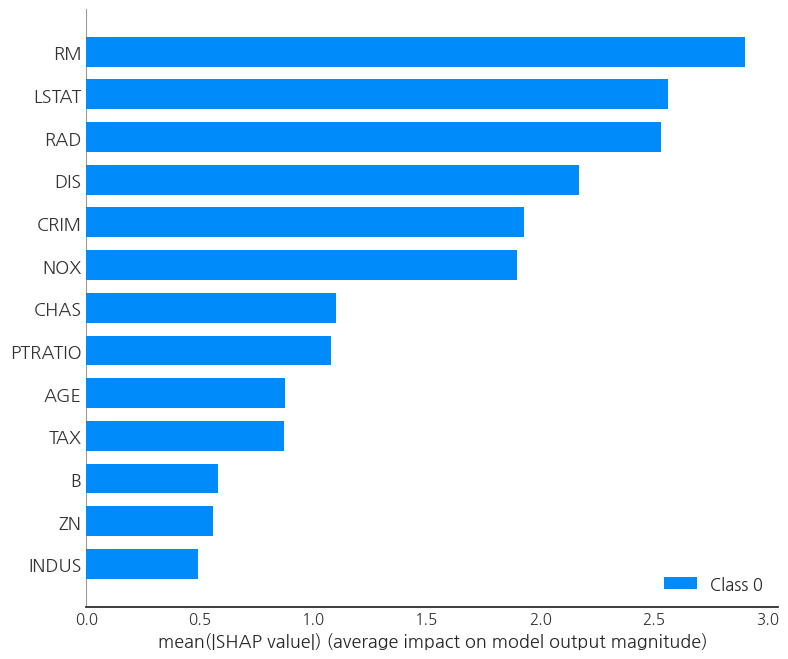

In [12]:
import shap

# SHAP 값 계산
# 딥러닝 모델, 특히 케라스나 텐서플로우 같은 프레임워크로 구축된 신경망 모델에 특화된 Explainer 사용
explainer = shap.DeepExplainer(model, train_data)
shap_values = explainer.shap_values(test_data)

# SHAP 요약 플롯
shap.summary_plot(shap_values, test_data, feature_names=feature_names)

In [20]:
# SHAP 초기화
shap.initjs()

# explainer.expected_value가 TensorFlow의 EagerTensor 형태로 반환되고 있어서 ndarray로 변환 필요
# expected_value를 일반 Python 숫자로 변환
expected_value = explainer.expected_value.numpy().item()

# SHAP force_plot 생성
shap.force_plot(expected_value, shap_values[0][0], test_data[0], feature_names=feature_names)

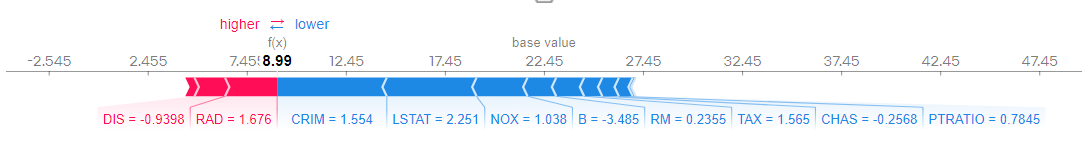

- 그래프를 해석해 보자면 아래와 같습니다.
    - $f(x)$ : 모델에 의해 예측된 값
    - `base value` : 모델이 데이터셋에 대해 평균적으로 예측하는 값
    - 색상
        - 파란색 : 예측값을 증가시키는 변수의 기여도
        - 붉은색 : 예측값을 감소시키는 변수의 기여도
    - Bar의 길이 : 해당 변수의 영향력의 크기 (길이가 길수록 모델 예측에 더 큰 영향을 미침)
    
---

- 종합적으로 보자면 각 변수의 평균 SHAP값으로 보자면 RM, LSTAT, RAD 등이 모델에 영향을 미치는 주요 변수들입니다.
- 그리고 각 변수의 세부적 특성들을 보자면 LSTAT, CRIM, NOX 등은 집값을 높이는데 주요한 변수인 반면, RAD, DIS는 집값을 낮추는데 주요한 영향을 미치는 변수들임을 알 수 있습니다.

### Permutation Importance 로 각 변수의 모델 기여도 판단

- Permutation Importance 는 각 특성을 하나씩 무작위로 섞어서 모델의 성능에 어떤 영향을 미치는지를 측정하는 방법을 말합니다.
- 즉, 각 특성들을 무작위로 섞은 후, 테스트 데이터로 모델 성능을 테스트 하고, 모델 성능을 평가합니다.
    - 성능평가는 MSE로 진행합니다.
    - 그리고 기존 성능과 섞인 변수의 성능의 차이를 각 특성의 중요도로 간주합니다.

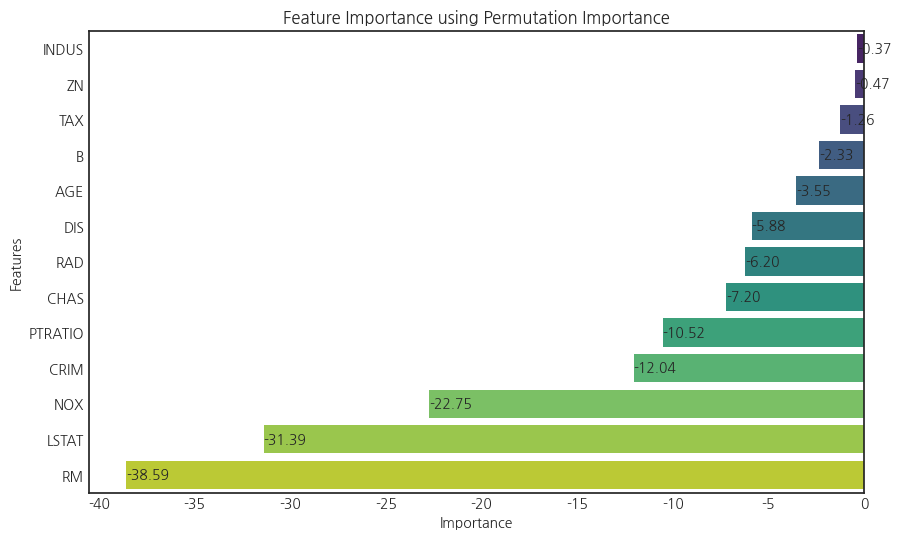

In [28]:
import pandas as pd

# 원래 모델의 성능 평가
original_score = mean_squared_error(test_labels, model.predict(test_data))

# 각 특성에 대한 중요도 계산
importances = {}
for i, name in enumerate(feature_names):
    shuffled_data = test_data.copy()
    shuffled_data[:, i] = shuffle(shuffled_data[:, i])
    shuffled_score = mean_squared_error(test_labels, model.predict(shuffled_data))
    importances[name] = original_score - shuffled_score

# 중요도를 DataFrame으로 변환
importance_df = pd.DataFrame(list(importances.items()), columns=['Feature', 'Importance'])
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Seaborn을 사용한 시각화
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='Importance', y='Feature', data=importance_df, palette="viridis", order=importance_df.sort_values(by='Importance', ascending=False)['Feature'])
plt.title('Feature Importance using Permutation Importance')
plt.xlabel('Importance')
plt.ylabel('Features')

# 각 막대에 수치 표시
for p in ax.patches:
    ax.annotate(f'{p.get_width():.2f}', (p.get_width(), p.get_y() + p.get_height()/2), ha='left', va='center')

plt.show()

# Closing

- 딥러닝을 활용한 간단한 회귀 예측을 하는 방법을 프로젝트로 구현해 봤습니다.
- 모델 자체의 구조는 매우 단순하기도 했고, 시작부터 결과값이 잘 나왔기 때문에 모델의 성능 향상보다는, XAI 개념에 입각해서 모델의 결과를 어떻게 하면 해석할 수 있을 가를 공부해서 내용을 추가했습니다.

---

## 회고

### KEEP
- 단순한 코드와 프로젝트여도, 추가적으로 뭘 하면서 내가 공부할 수 있을 까를 고민한 것.
- 데이터 분석 자체에 관심이 많기 때문에 이에 대한 관점을 놓치지 않고 더 공부하려고 한 것.

### PROBLEM
- 개념에 대한 완벽한 이해보다는 단순히 레퍼런스를 기반으로 코드 구현만 한것
- 단순 신경망 외에 딥러닝에 기반한 회귀모델(i.e: MLPRegressor 등) 을 구축해서 활용해보지 못한 것

### TRY
- SHAP나 Permutation importance 모두 결과를 만들어 내는 방식은 비슷한 관점에서 시작하는데 차이가 있는데, 아직 명확하게 이해를 못해서, 이에 대한 추가적인 공부를 시도할 것!